# Bus Stop Clustering and Typology — Analysis Notebook

This notebook documents the modeling and analysis code used in the study, starting after all raw AFC/APC, GPS, and ODX data cleaning and integration steps. The raw datasets are not publicly available; here we work only with the aggregated stop-level indicators derived from that preprocessing.

The workflow in this notebook is organized as follows:

1. Gaussian Mixture Model (GMM) tuning  
2. Final GMM clustering and type profiles  
3. Type interpretation with one-vs-rest Random Forest models  
4. Multiclass XGBoost tuning and separability assessment  

Together, these steps reconstruct the full clustering, type interpretation, and separability analysis pipeline used in the study.


## 1. GMM model selection: BIC elbow

In this section, we explore different Gaussian Mixture Model specifications for the stop-level feature space. We vary:

- the number of components \(K\), and  
- the covariance structure (`full`, `tied`, `diag`, `spherical`),

and compute the Bayesian Information Criterion (BIC) for each candidate. The goal is not to pick \(K\) purely mechanically, but to narrow the search to a small set of plausible combinations that balance model fit and parsimony. The resulting “elbow” plot helps guide the choice of the final GMM used for the typology.


In [3]:
import math
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import cm

import seaborn as sns
from pandas.plotting import parallel_coordinates

from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, f1_score, log_loss,
    precision_score, recall_score, roc_auc_score,
    confusion_matrix, classification_report,
    precision_recall_fscore_support, roc_curve, auc
)

from sklearn.inspection import permutation_importance

import shap

# Optional: only used if installed
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False


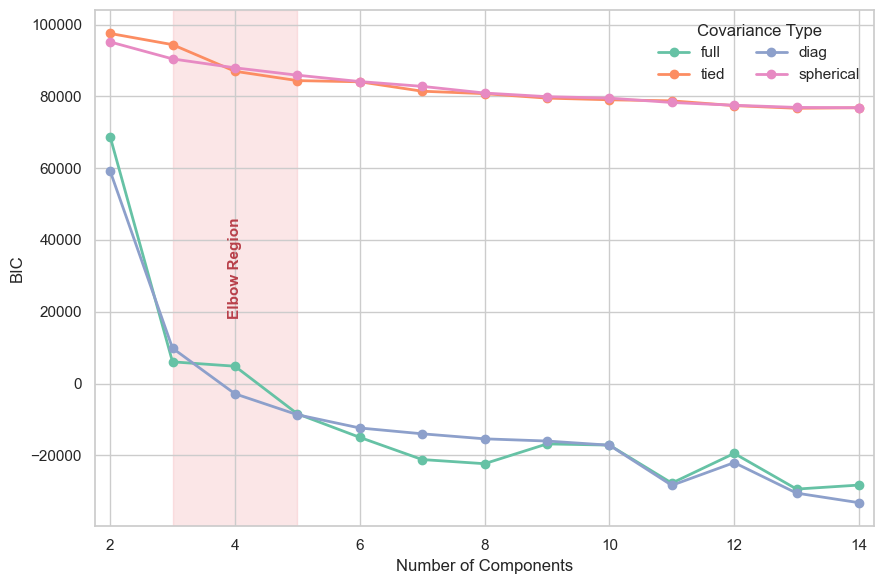

In [4]:
# ---------- Config ----------
CSV = "stop_overall_averages_with_dist.csv"
FEATURES = [
    'avg_headway_min','avg_dwell_mins','avg_schedule_deviation','num_unique_routes',
    'avg_APC_count','avg_psgrload','avg_psgroff','avg_transfer','NI_rate','nearest_station_dist_m'
]
COV_TYPES = ['full', 'tied', 'diag', 'spherical']
K_RANGE = range(2, 15)           # 2–14
ELBOW_LO, ELBOW_HI = 3, 5        # highlight this region

# ---------- Load & scale ----------
df = pd.read_csv(CSV)
X = df[FEATURES].to_numpy()
X = StandardScaler().fit_transform(X)

# ---------- Compute BICs ----------
sns.set(style="whitegrid")
plt.figure(figsize=(9, 6))
colors = sns.color_palette("Set2", len(COV_TYPES))

for color, cov in zip(colors, COV_TYPES):
    bics = []
    for k in K_RANGE:
        gmm = GaussianMixture(n_components=k, covariance_type=cov, random_state=42, n_init=5)
        gmm.fit(X)
        bics.append(gmm.bic(X))
    plt.plot(K_RANGE, bics, marker='o', linewidth=2, color=color, label=cov)

# ---------- Shade elbow region ----------
ax = plt.gca()
ax.axvspan(ELBOW_LO, ELBOW_HI, color="#f29ca3", alpha=0.25, zorder=0)

# Place text in the middle of the shaded region
mid_x = (ELBOW_LO + ELBOW_HI) / 2
mid_y = (ax.get_ylim()[0] + ax.get_ylim()[1]) / 2   # vertical midpoint
ax.text(mid_x, mid_y, "Elbow Region",
        ha="center", va="center", rotation=90,
        color="#b8404a", fontsize=11, weight="bold")


# ---------- Aesthetics ----------
plt.xlabel("Number of Components", fontsize=12)
plt.ylabel("BIC", fontsize=12)
plt.legend(title="Covariance Type", frameon=False, ncol=2)
plt.margins(x=0.02)
plt.tight_layout()
plt.savefig("bic_gmm_elbow_3to5.png", dpi=300)
plt.show()


## 2. Final GMM clustering and cluster assignment

Based on the BIC diagnostics and interpretability checks, we select a final GMM specification with \(K = 4\) components. In this step, we:

- fit the chosen GMM to the standardized stop-level indicators, and  
- assign each stop to one of the four latent components.  

The resulting cluster labels are saved back to the stop-level dataset for downstream profiling, visualization, and validation.


In [5]:
# Config
# --------------------
N_CLUSTERS = 4
INPUT_CSV  = 'stop_overall_averages_with_dist.csv'
OUT_CSV    = 'stop_overall_averages_with_dist_clustered.csv'

# 1) Load
df = pd.read_csv(INPUT_CSV)

# 2) Features to cluster on
cols = [
    'avg_headway_min',
    'avg_dwell_mins',
    'num_unique_routes',
    'avg_APC_count',
    'avg_psgrload',
    'avg_psgroff',
    'avg_transfer',
    'NI_rate',
    'nearest_station_dist_m'
]

# 3) Standard-scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[cols])

# 4) Fit a 4-component diagonal-covariance GMM
gmm = GaussianMixture(
    n_components=N_CLUSTERS,
    covariance_type='diag',
    random_state=42,
    n_init=5
)
labels = gmm.fit_predict(X_scaled)
df['cluster'] = labels

# quick report
counts = pd.Series(labels).value_counts().sort_index()
print("Cluster sizes:", counts.to_dict())

df.to_csv(OUT_CSV, index=False)
print(f"Wrote: {OUT_CSV}")


Cluster sizes: {0: 528, 1: 979, 2: 375, 3: 1950}
Wrote: stop_overall_averages_with_dist_clustered.csv


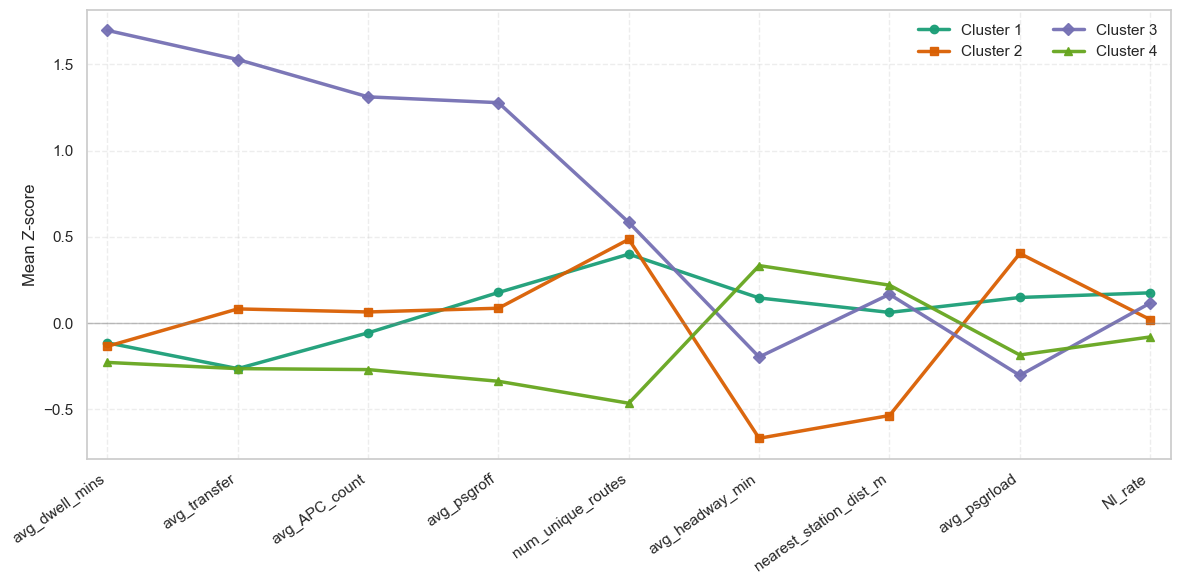

In [6]:
# ---------- Config ----------
CSV = "stop_overall_averages_with_dist_clustered.csv"
FEATURES = [
    'avg_headway_min',
    'avg_dwell_mins',
    'num_unique_routes',
    'avg_APC_count',
    'avg_psgrload',
    'avg_psgroff',
    'avg_transfer',
    'NI_rate',
    'nearest_station_dist_m'
]
CLUSTER_COL = "cluster"

# ---------- Load ----------
df = pd.read_csv(CSV)
df[CLUSTER_COL] = pd.to_numeric(df[CLUSTER_COL], errors="coerce").astype('Int64')

# ---------- Z-score the features ----------
scaler = StandardScaler()
Xz = scaler.fit_transform(df[FEATURES])
df_z = pd.DataFrame(Xz, columns=FEATURES, index=df.index)
df_z[CLUSTER_COL] = df[CLUSTER_COL].values

# ---------- Per-cluster means in Z-space ----------
cluster_means = (
    df_z.groupby(CLUSTER_COL, dropna=True)[FEATURES]
        .mean()
        .sort_index()
)

# variance across clusters for each feature
sep = cluster_means.var(axis=0).sort_values(ascending=False)
ordered_features = sep.index.tolist()

# ---------- Plot ----------
colors = ["#1b9e77", "#d95f02", "#7570b3", "#66a61e"]  # colorblind-friendly
markers = ["o", "s", "D", "^"]

x = np.arange(len(ordered_features))

plt.figure(figsize=(12, 6))
for i, (cid, row) in enumerate(cluster_means.iterrows()):
    y = row[ordered_features].values
    lbl = f"Cluster {int(cid)+1}"
    plt.plot(x, y, linewidth=2.5, color=colors[i % len(colors)], marker=markers[i % len(markers)],
             markersize=6, label=lbl, alpha=0.95)

# aesthetics
plt.xticks(x, ordered_features, rotation=35, ha='right')
plt.ylabel("Mean Z-score")
plt.grid(True, linestyle="--", alpha=0.35)
plt.axhline(0, color="gray", linewidth=1, alpha=0.5)
plt.margins(x=0.02)
plt.legend(frameon=False, ncol=2)
plt.tight_layout()
plt.savefig("parallel_coords_means_pretty.png", dpi=300)
plt.show()


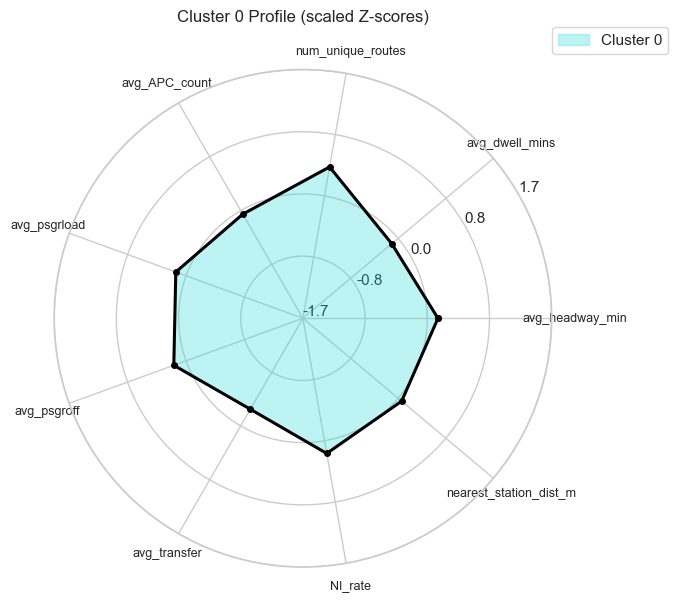

Saved: cluster_plots\cluster_0_spider.png


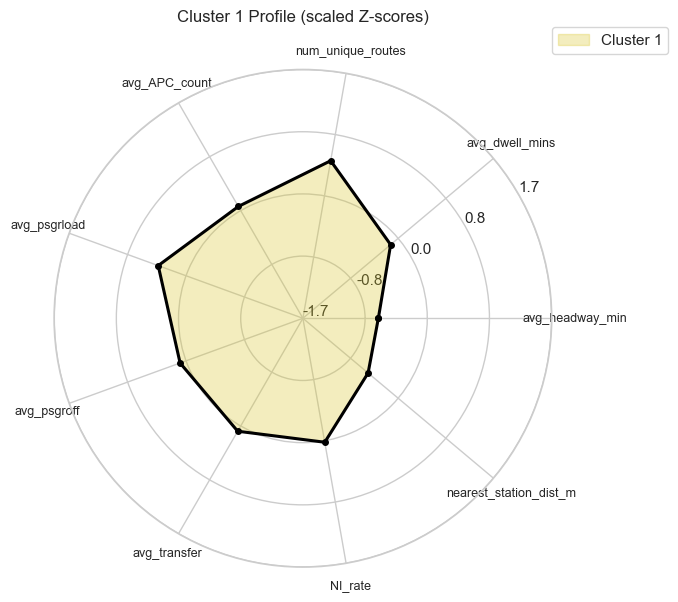

Saved: cluster_plots\cluster_1_spider.png


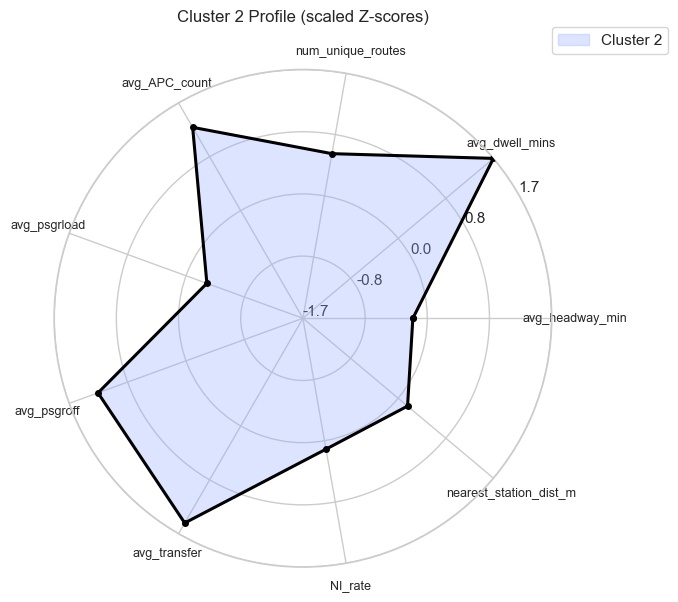

Saved: cluster_plots\cluster_2_spider.png


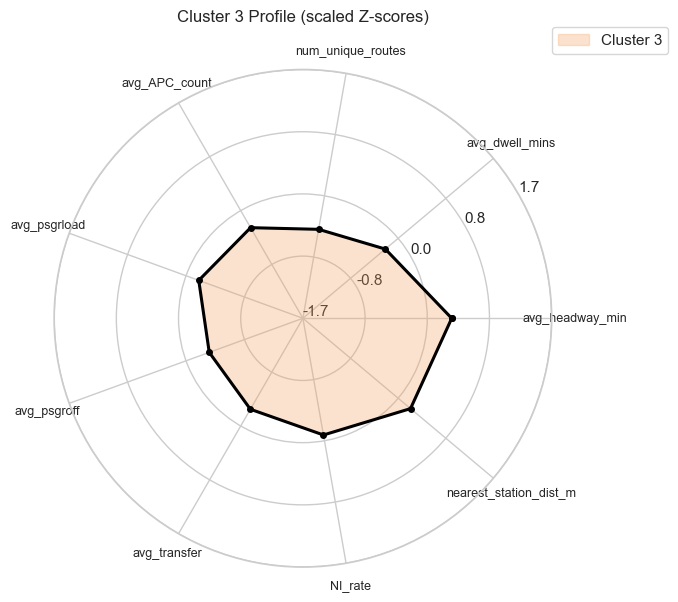

Saved: cluster_plots\cluster_3_spider.png


In [7]:
# ---------- Config ----------
CSV = "stop_overall_averages_with_dist_clustered.csv"
FEATURES = [
    'avg_headway_min','avg_dwell_mins','num_unique_routes','avg_APC_count',
    'avg_psgrload','avg_psgroff','avg_transfer','NI_rate','nearest_station_dist_m'
]
CLUSTER_COL = "cluster"
OUT_DIR = Path("cluster_plots"); OUT_DIR.mkdir(exist_ok=True)

# Palette: 1→cyan, 2→(darker) yellow, 3→periwinkle, 4→orange
# (yellow darkened for visibility)
PALETTE_1to4 = ['#27D9D5', '#D8C62A', '#8FA8FF', '#F4A261']
PALETTE_0to3 = PALETTE_1to4[:]  # same mapping if labels are 0..3

# ---------- Load & z-score ----------
df = pd.read_csv(CSV)
df[CLUSTER_COL] = pd.to_numeric(df[CLUSTER_COL], errors="coerce").astype('Int64')

scaler = StandardScaler()
Xz = scaler.fit_transform(df[FEATURES])
df_z = pd.DataFrame(Xz, columns=FEATURES, index=df.index)
df_z[CLUSTER_COL] = df[CLUSTER_COL].values

# Per-cluster means (Z-space)
cluster_means = (
    df_z.groupby(CLUSTER_COL, dropna=True)[FEATURES]
        .mean()
        .reset_index()
        .sort_values(CLUSTER_COL)
)

# Detect label scheme
clusters = cluster_means[CLUSTER_COL].to_list()
use_0to3 = set(clusters) == set(range(0, 4))
use_1to4 = set(clusters) == set(range(1, 5))
if not (use_0to3 or use_1to4):
    uniq = sorted(clusters)
    label_to_idx = {lab: i for i, lab in enumerate(uniq)}
else:
    label_to_idx = None

# ---------- Shared radial limits ----------
gmin = cluster_means[FEATURES].to_numpy().min()
gmax = cluster_means[FEATURES].to_numpy().max()
amax = max(abs(gmin), abs(gmax))
rmin, rmax = -amax, amax

num_vars = len(FEATURES)
angles = np.linspace(0, 2*np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

for _, row in cluster_means.iterrows():
    k = int(row[CLUSTER_COL])
    vals = row[FEATURES].tolist(); vals += vals[:1]

    # choose fill color
    if label_to_idx is not None:
        idx = label_to_idx[k]
        fill_color = PALETTE_0to3[idx]
    elif use_1to4:
        fill_color = PALETTE_1to4[k-1]
    else:
        fill_color = PALETTE_0to3[k]

    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(polar=True))

    ax.fill(angles, vals, color=fill_color, alpha=0.30, zorder=2)
    ax.plot(angles, vals, color='black', linewidth=2.2, marker='o',
            markersize=4, markerfacecolor='black', markeredgecolor='black', zorder=3)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(FEATURES, fontsize=9)
    ax.set_title(f"Cluster {k} Profile (scaled Z-scores)", y=1.08)

    ax.set_ylim(rmin, rmax)
    ticks = np.linspace(rmin, rmax, 5)
    ax.set_yticks(ticks)
    ax.set_yticklabels([f"{t:.1f}" for t in ticks])
    ax.set_rlabel_position(30)

    # optional legend chip showing fill color + black outline
    ax.plot([], [], color='black', linewidth=2.2)
    ax.fill([], [], color=fill_color, alpha=0.30, label=f"Cluster {k}")
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.10))

    plt.tight_layout()
    out_png = OUT_DIR / f"cluster_{k}_spider.png"
    plt.savefig(out_png, dpi=220)
    plt.show()
    plt.close(fig)
    print(f"Saved: {out_png}")


Saved: feature_dist_plots\all_features_histograms.png


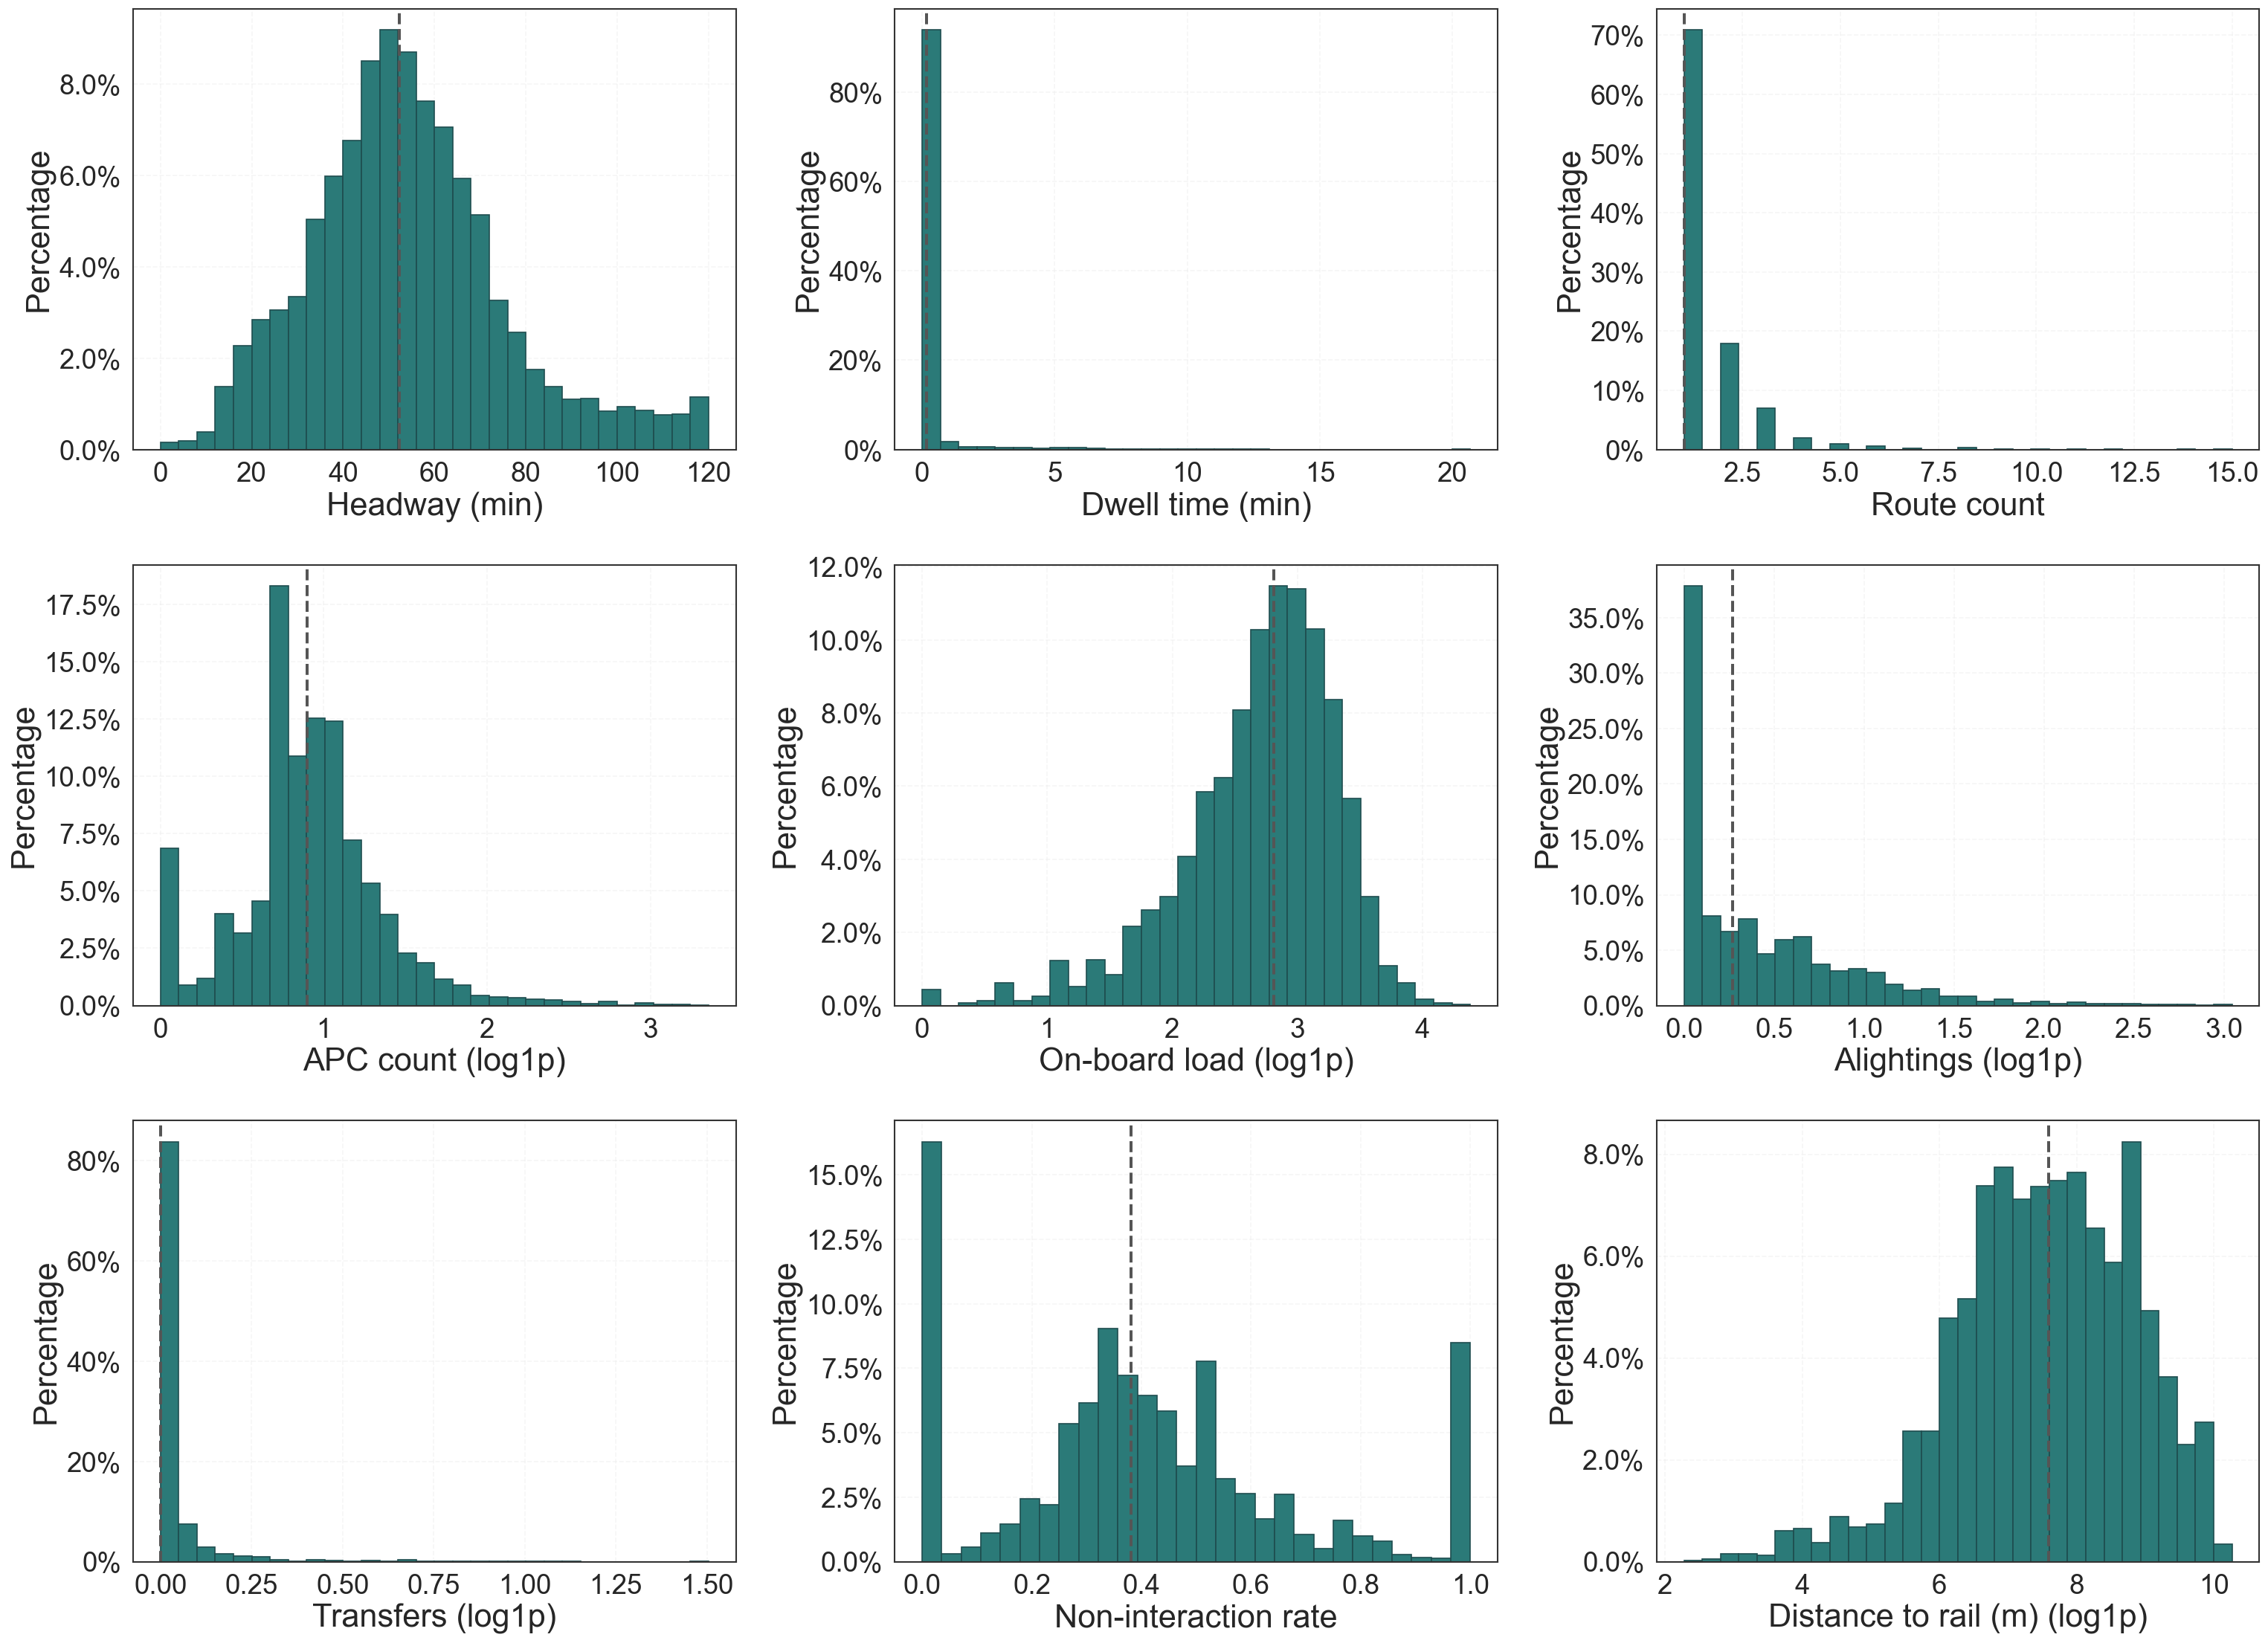

In [8]:
CSV = "stop_overall_averages_with_dist_clustered.csv"
OUT = Path("feature_dist_plots"); OUT.mkdir(exist_ok=True)
FIGPATH = OUT / "all_features_histograms.png"

# ---- global knobs ----
SCALE        = 2      # resize everything uniformly
BOLD_LABELS  = False     # bold all x/y axis labels
SHOW_SUPTITLE = False    # show a single title at the very top

# ---- 3x3 order ----
FEATURES_IN_ORDER = [
    "avg_headway_min", "avg_dwell_mins", "num_unique_routes",
    "avg_APC_count",   "avg_psgrload",   "avg_psgroff",
    "avg_transfer",    "NI_rate",        "nearest_station_dist_m",
]

# Labels for axes (used only on x-axis now)
DISPLAY = {
    "avg_headway_min":        "Headway (min)",
    "avg_dwell_mins":         "Dwell time (min)",
    "avg_APC_count":          "APC count",
    "avg_psgrload":           "On-board load",
    "avg_psgroff":            "Alightings",
    "num_unique_routes":      "Route count",
    "avg_transfer":           "Transfers",
    "NI_rate":                "Non-interaction rate",
    "nearest_station_dist_m": "Distance to rail (m)",
}

# log1p for skewed features
LOG_X = {
    "avg_headway_min": False,
    "avg_dwell_mins":  False,
    "avg_APC_count":   True,
    "avg_psgrload":    True,
    "avg_psgroff":     True,
    "num_unique_routes": False,
    "avg_transfer":    True,
    "NI_rate":         False,
    "nearest_station_dist_m": True,
}

SHOW_MEDIAN = {k: True for k in FEATURES_IN_ORDER}

# ---- style ----
plt.rcParams.update({
    "figure.dpi": 120,
    "font.size":          13 * SCALE,
    "axes.titlesize":     15 * SCALE,   # (unused; no titles)
    "axes.labelsize":     13 * SCALE,
    "xtick.labelsize":     11 * SCALE,
    "ytick.labelsize":     11 * SCALE,
    "axes.edgecolor": "#333333",
    "grid.color":  "#e6e6e6",
})
BAR_COLOR    = "#2b7a78"
EDGE_COLOR   = "#1e4d4f"
MEDIAN_COLOR = "#555555"
LINEWIDTH    = 0.5 * SCALE
MEDIAN_LW    = 1.2 * SCALE
LABEL_WEIGHT = "bold" if BOLD_LABELS else "normal"

def freedman_diaconis_bins(a, max_bins=30):
    a = np.asarray(a); a = a[np.isfinite(a)]
    n = a.size
    if n < 2: return 10
    iqr = np.subtract(*np.percentile(a, [75, 25]))
    if iqr <= 0: return min(max_bins, max(8, int(np.sqrt(n))))
    bw = 2 * iqr * n ** (-1/3)
    return int(np.clip((a.max() - a.min()) / max(bw, 1e-12), 8, max_bins))

# ---- load ----
df = pd.read_csv(CSV)

# ---- figure ----
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(13 * SCALE, 9.5 * SCALE))
axes = axes.ravel()

for ax, feat in zip(axes, FEATURES_IN_ORDER):
    s = pd.to_numeric(df[feat], errors="coerce").dropna()
    if s.empty:
        ax.set_visible(False); continue

    x = np.log1p(s) if LOG_X.get(feat, False) else s
    xlabel = DISPLAY[feat] + (" (log1p)" if LOG_X.get(feat, False) else "")

    weights = np.ones_like(x, dtype=float) / x.size
    bins = freedman_diaconis_bins(x)
    ax.hist(x, bins=bins, weights=weights,
            color=BAR_COLOR, edgecolor=EDGE_COLOR, linewidth=LINEWIDTH)

    if SHOW_MEDIAN.get(feat, True):
        ax.axvline(np.median(x), ls="--", lw=MEDIAN_LW, color=MEDIAN_COLOR)

    # no subplot titles
    ax.set_xlabel(xlabel, labelpad=2 * SCALE, fontweight=LABEL_WEIGHT)
    ax.set_ylabel("Percentage", fontweight=LABEL_WEIGHT)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    ax.grid(True, linestyle="--", alpha=0.35)

if SHOW_SUPTITLE:
    fig.suptitle("Distributions of stop-level indicators", y=0.995,
                 fontsize=13 * SCALE, fontweight="bold")

fig.tight_layout(rect=[0, 0, 1, 0.985 if SHOW_SUPTITLE else 1.0])
fig.savefig(FIGPATH, dpi=300, bbox_inches="tight")
print(f"Saved: {FIGPATH}")

plt.show()


C:\Users\IT CITY\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\IT CITY\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\IT CITY\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\IT CITY\anaconda3\Lib\site-packages\seaborn\categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

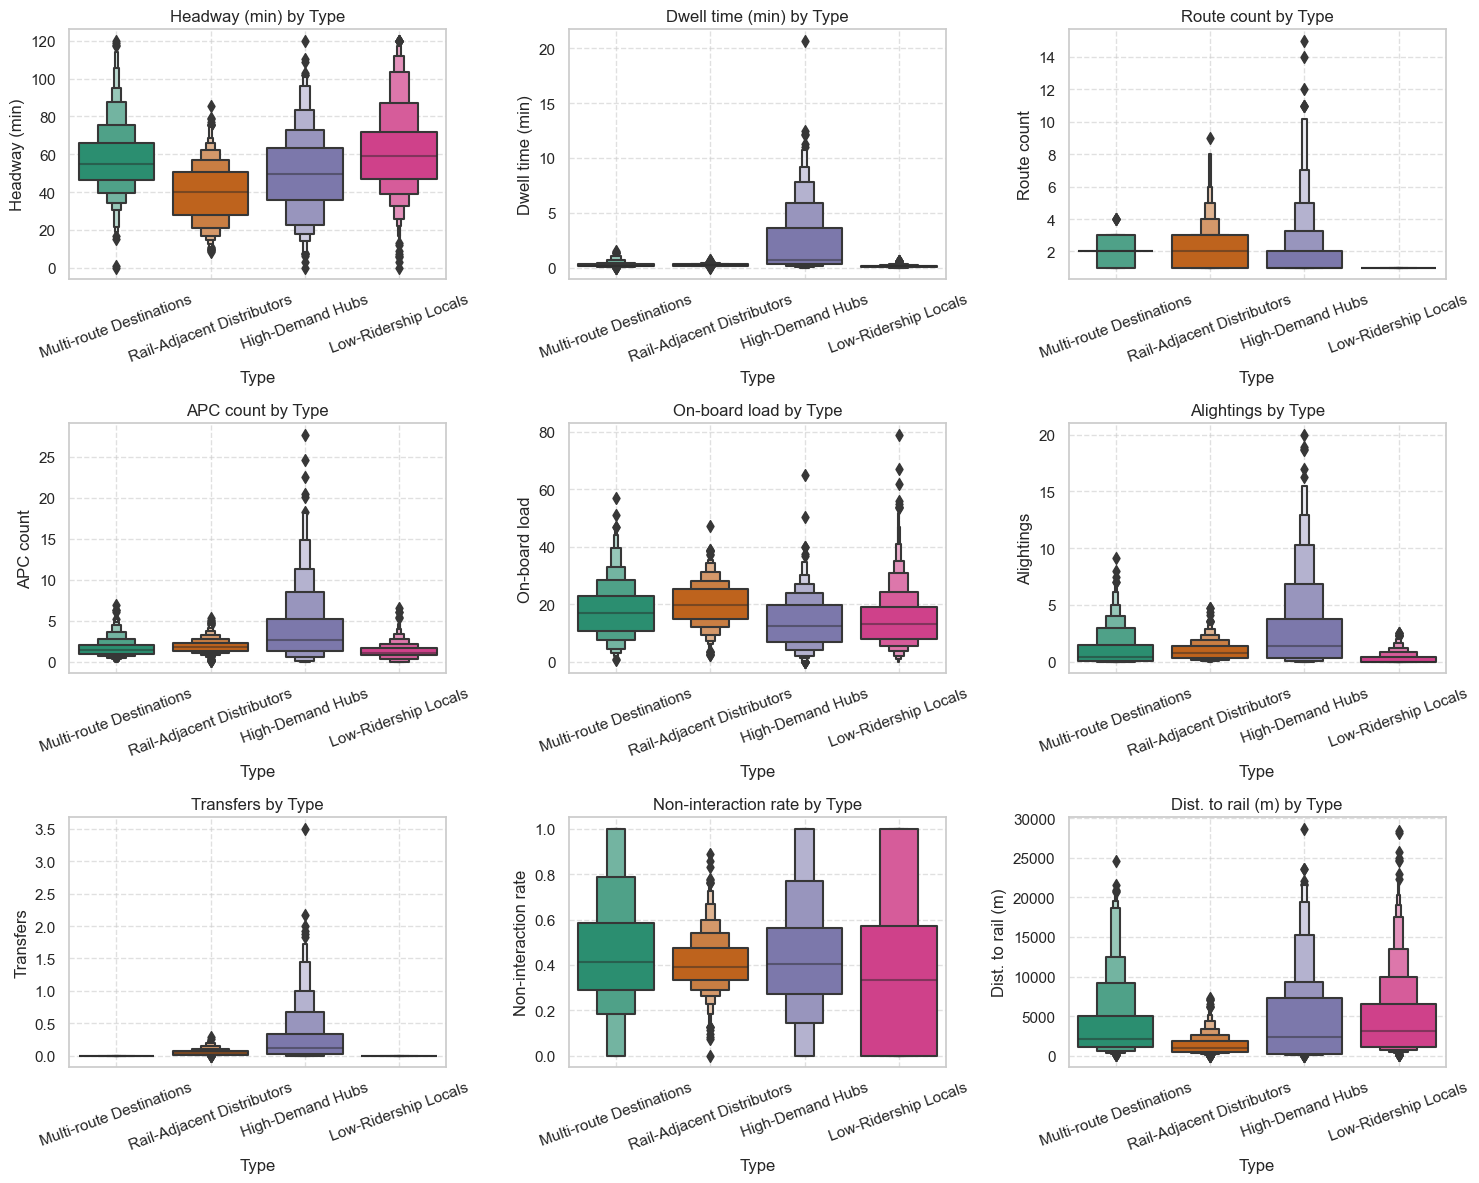

In [6]:
df = pd.read_csv('stop_overall_averages_with_dist_clustered.csv')
CLUSTER_COL = 'cluster'

FEATURES = [
    'avg_headway_min','avg_dwell_mins','num_unique_routes','avg_APC_count',
    'avg_psgrload','avg_psgroff','avg_transfer','NI_rate','nearest_station_dist_m'
]
DISPLAY_NAME = {
    'avg_headway_min':        'Headway (min)',
    'avg_dwell_mins':         'Dwell time (min)',
    'num_unique_routes':      'Route count',
    'avg_APC_count':          'APC count',
    'avg_psgrload':           'On-board load',
    'avg_psgroff':            'Alightings',
    'avg_transfer':           'Transfers',
    'NI_rate':                'Non-interaction rate',
    'nearest_station_dist_m': 'Dist. to rail (m)',
}

TYPE_NAME_MAP_1to4 = {
    1: 'Multi-route Destinations',
    2: 'Rail-Adjacent Distributors',
    3: 'High-Demand Hubs',
    4: 'Low-Ridership Locals',
}
TYPE_NAME_MAP_0to3 = {
    0: 'Multi-route Destinations',
    1: 'Rail-Adjacent Distributors',
    2: 'High-Demand Hubs',
    3: 'Low-Ridership Locals',
}

PALETTE = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']  # green, orange, purple, magenta

df[CLUSTER_COL] = pd.to_numeric(df[CLUSTER_COL], errors='coerce')

labels = sorted(df[CLUSTER_COL].dropna().unique())
use_0to3 = set(labels) == set(range(0, 4))
use_1to4 = set(labels) == set(range(1, 5))

if use_0to3:
    type_name_map = TYPE_NAME_MAP_0to3
    order = [0,1,2,3]
elif use_1to4:
    type_name_map = TYPE_NAME_MAP_1to4
    order = [1,2,3,4]
else:
    order = labels
    type_name_map = {lab: f"Type {i+1}" for i, lab in enumerate(order)}

df['Type'] = df[CLUSTER_COL].map(type_name_map)
type_order = [type_name_map[k] for k in order]

type_to_color = {type_name_map[k]: PALETTE[i % len(PALETTE)] for i, k in enumerate(order)}

features = FEATURES
n_features = len(features)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), sharex=False)
axes = axes.flatten()

for i, feat in enumerate(features):
    ax = axes[i]
    # Use consistent palette and order
    sns.boxenplot(
        x='Type', y=feat, data=df,
        order=type_order,
        palette=type_to_color,
        ax=ax
    )
    ax.set_xlabel("Type")
    ax.set_ylabel(DISPLAY_NAME[feat])
    ax.set_title(f"{DISPLAY_NAME[feat]} by Type")
    ax.grid(True, linestyle="--", alpha=0.6)
    # Rotate x labels for readability
    ax.tick_params(axis='x', rotation=20)

# Hide any unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("all_boxenplots.png", dpi=300)
plt.show()


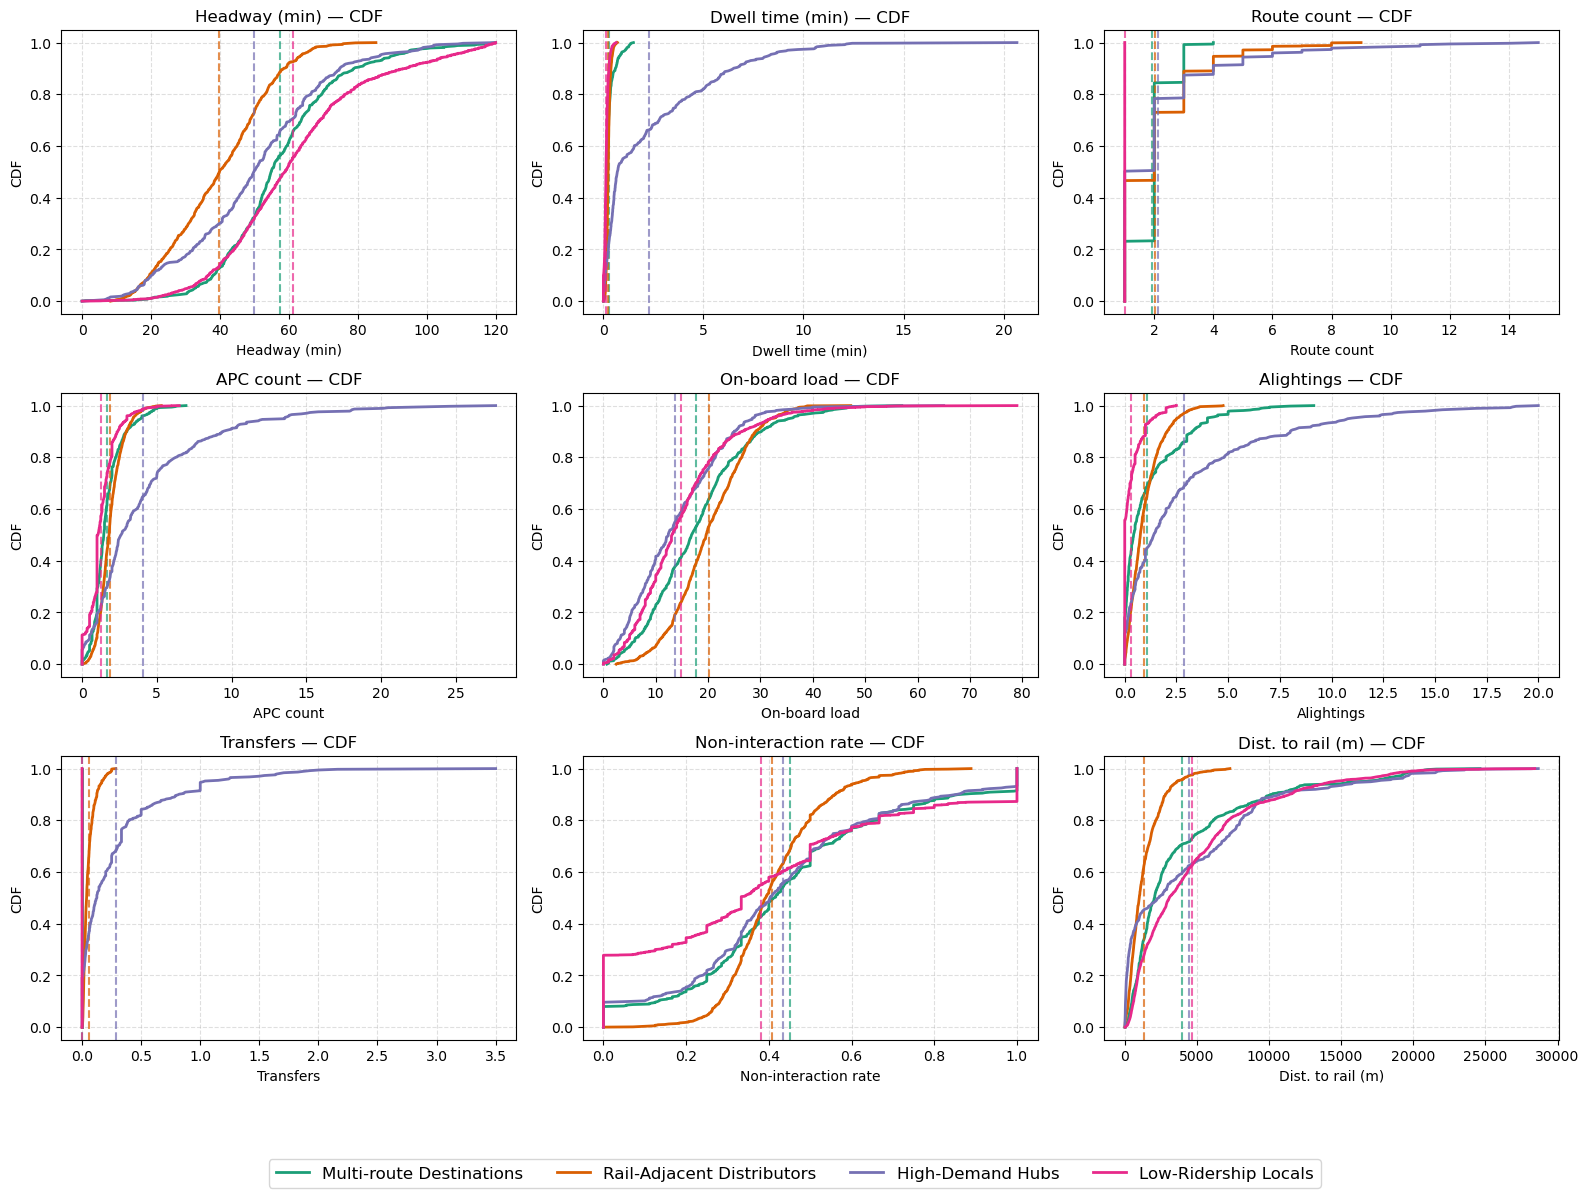

In [2]:
# ------------------------------
# 1) Load
# ------------------------------
df = pd.read_csv('stop_overall_averages_with_dist_clustered.csv')
CLUSTER_COL = 'cluster'

# ------------------------------
# 2) Feature display names
# ------------------------------
FEATURES = [
    'avg_headway_min','avg_dwell_mins','num_unique_routes','avg_APC_count',
    'avg_psgrload','avg_psgroff','avg_transfer','NI_rate','nearest_station_dist_m'
]
DISPLAY_NAME = {
    'avg_headway_min':        'Headway (min)',
    'avg_dwell_mins':         'Dwell time (min)',
    'num_unique_routes':      'Route count',
    'avg_APC_count':          'APC count',
    'avg_psgrload':           'On-board load',
    'avg_psgroff':            'Alightings',
    'avg_transfer':           'Transfers',
    'NI_rate':                'Non-interaction rate',
    'nearest_station_dist_m': 'Dist. to rail (m)',
}

# ------------------------------
# 3) Type names
# ------------------------------
TYPE_NAME_MAP_1to4 = {
    1: 'Multi-route Destinations',
    2: 'Rail-Adjacent Distributors',
    3: 'High-Demand Hubs',
    4: 'Low-Ridership Locals',
}
TYPE_NAME_MAP_0to3 = {
    0: 'Multi-route Destinations',
    1: 'Rail-Adjacent Distributors',
    2: 'High-Demand Hubs',
    3: 'Low-Ridership Locals',
}

# ------------------------------
# 4) Palette (same as spider plots)
# ------------------------------
PALETTE = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']

# ------------------------------
# 5) Normalize labels, maps, palette
# ------------------------------
df[CLUSTER_COL] = pd.to_numeric(df[CLUSTER_COL], errors='coerce')

labels = sorted(df[CLUSTER_COL].dropna().unique())

use_0to3 = set(labels) == set(range(0,4))
use_1to4 = set(labels) == set(range(1,5))

if use_0to3:
    type_name_map = TYPE_NAME_MAP_0to3
    order = [0,1,2,3]
elif use_1to4:
    type_name_map = TYPE_NAME_MAP_1to4
    order = [1,2,3,4]
else:
    order = labels
    type_name_map = {lab: f"Type {i+1}" for i, lab in enumerate(order)}

df['Type'] = df[CLUSTER_COL].map(type_name_map)
type_order = [type_name_map[o] for o in order]

type_to_color = {
    type_name_map[o]: PALETTE[i % len(PALETTE)]
    for i, o in enumerate(order)
}

# ------------------------------
# 6) ECDF plot grid
# ------------------------------
n_features = len(FEATURES)
n_cols = 3
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4))
axes = axes.flatten()

# We'll store handles (one per Type) from the *first* subplot
legend_handles = {}
legend_labels = []

for i, feat in enumerate(FEATURES):
    ax = axes[i]

    for t in type_order:
        vals = df.loc[df['Type'] == t, feat].dropna().sort_values()
        if len(vals) == 0:
            continue

        yvals = np.linspace(0, 1, len(vals), endpoint=True)

        # Only create legend handles on the first feature (i == 0)
        if i == 0:
            line, = ax.plot(
                vals, yvals,
                label=t,
                color=type_to_color[t],
                linewidth=2
            )
            legend_handles[t] = line
            if t not in legend_labels:
                legend_labels.append(t)
        else:
            ax.plot(
                vals, yvals,
                color=type_to_color[t],
                linewidth=2
            )

        # Vertical mean line
        mean_val = vals.mean()
        ax.axvline(mean_val,
                   color=type_to_color[t],
                   linestyle="--",
                   alpha=0.7)

    ax.set_title(f"{DISPLAY_NAME[feat]} — CDF")
    ax.set_xlabel(DISPLAY_NAME[feat])
    ax.set_ylabel("CDF")
    ax.grid(True, linestyle="--", alpha=0.4)

# Hide any unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ------------------------------
# 7) Shared legend with correct colors
# ------------------------------
handles = [legend_handles[t] for t in legend_labels]
fig.legend(handles, legend_labels,
           loc='lower center',
           ncol=4,
           fontsize=12)

plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.savefig("all_CDF_plots.png", dpi=300)
plt.show()


## 3. One-vs-rest Random Forests for type interpretation

The GMM defines four latent types, but we still need to understand **what makes each type distinct** in terms of the original indicators. In this section, we:

- train separate one-vs-rest Random Forest classifiers for each type, using the same stop-level features, and  
- use SHAP values to explain which indicators push stops toward or away from each type.  

This step is focused on **interpretation**, not on building the “best” predictive model. The per-type SHAP beeswarm plots reveal, for example, that transfer activity and route count are central to high-connectivity stops, while dwell time, load, and alightings shape the profiles of high-demand hubs versus low-ridership locals.


Unique classes in y: [0 1 2 3]
Class distribution:
 cluster
3    1950
1     979
0     528
2     375
Name: count, dtype: int64

Training one-vs-rest RF for class 0: Multi-route Destinations
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best RF parameters (OVR): {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Test Accuracy: 0.9930434782608696

Classification Report:
               precision    recall  f1-score   support

           0      0.995     0.997     0.996       992
           1      0.981     0.968     0.975       158

    accuracy                          0.993      1150
   macro avg      0.988     0.983     0.985      1150
weighted avg      0.993     0.993     0.993      1150

sv_pos shape: (1150, 9) | X_test_df_disp shape: (1150, 9)


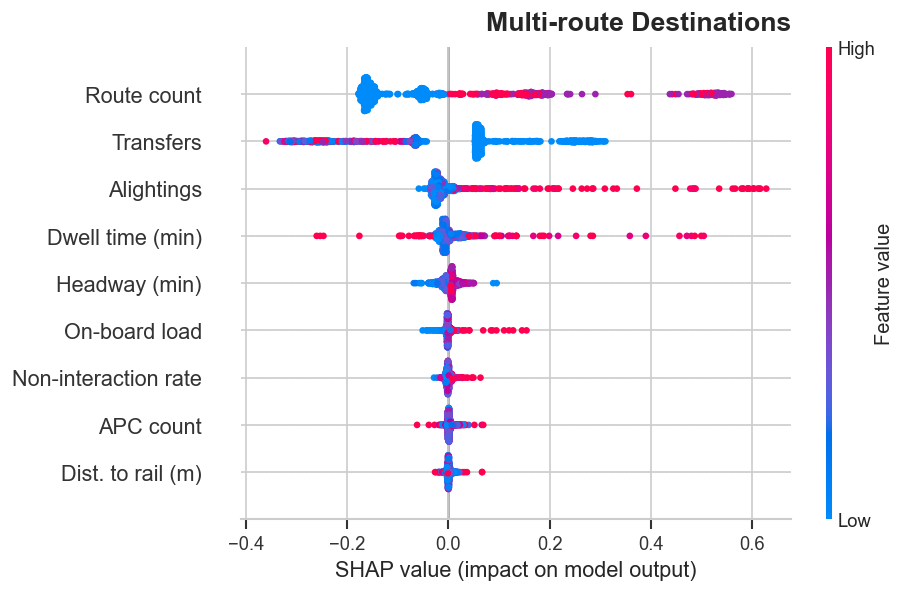


Training one-vs-rest RF for class 1: Rail-Adjacent Distributors
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best RF parameters (OVR): {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Test Accuracy: 0.9895652173913043

Classification Report:
               precision    recall  f1-score   support

           0      0.994     0.992     0.993       856
           1      0.976     0.983     0.980       294

    accuracy                          0.990      1150
   macro avg      0.985     0.987     0.986      1150
weighted avg      0.990     0.990     0.990      1150

sv_pos shape: (1150, 9) | X_test_df_disp shape: (1150, 9)


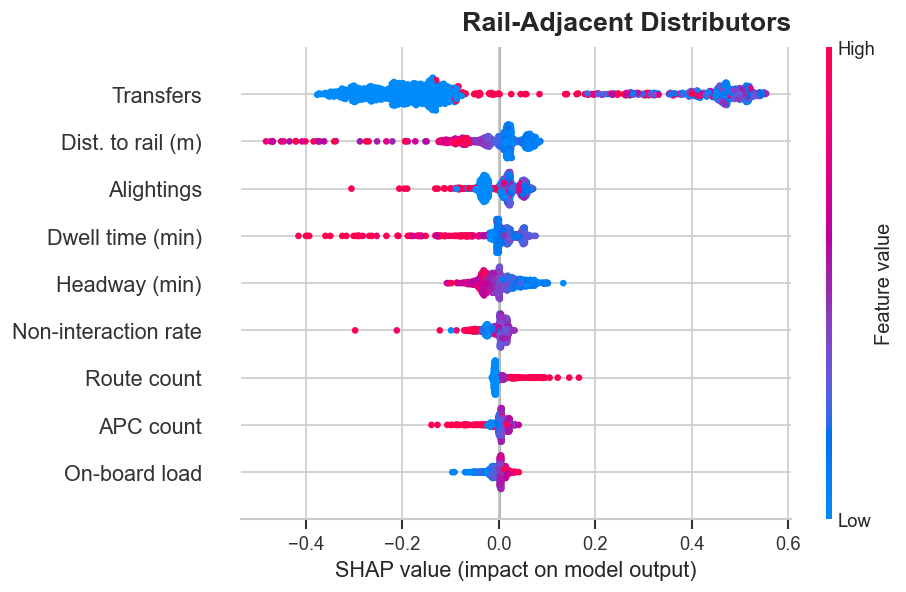


Training one-vs-rest RF for class 2: High-Demand Hubs
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best RF parameters (OVR): {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Test Accuracy: 0.9817391304347826

Classification Report:
               precision    recall  f1-score   support

           0      0.982     0.998     0.990      1037
           1      0.979     0.832     0.900       113

    accuracy                          0.982      1150
   macro avg      0.981     0.915     0.945      1150
weighted avg      0.982     0.982     0.981      1150

sv_pos shape: (1150, 9) | X_test_df_disp shape: (1150, 9)


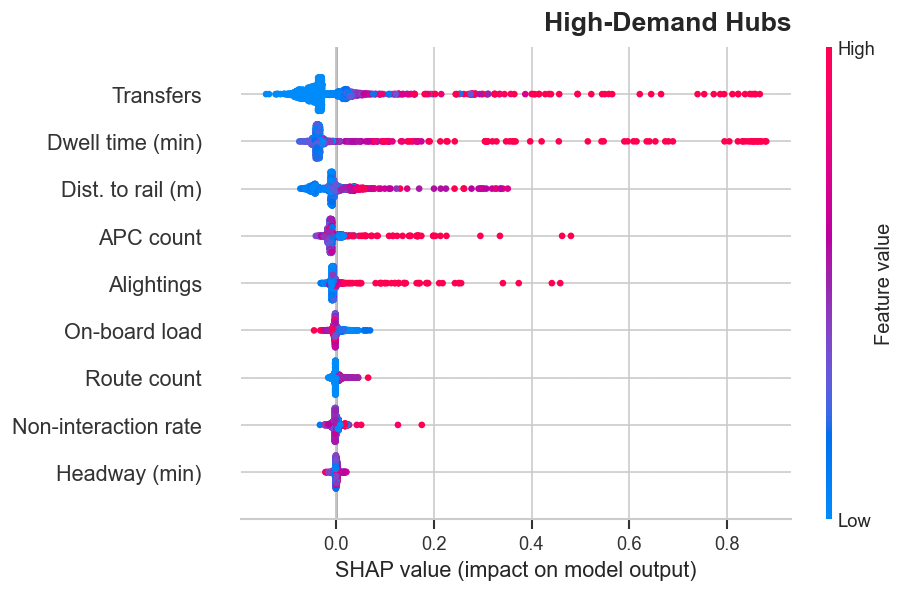


Training one-vs-rest RF for class 3: Low-Ridership Locals
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best RF parameters (OVR): {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Test Accuracy: 0.9991304347826087

Classification Report:
               precision    recall  f1-score   support

           0      1.000     0.998     0.999       565
           1      0.998     1.000     0.999       585

    accuracy                          0.999      1150
   macro avg      0.999     0.999     0.999      1150
weighted avg      0.999     0.999     0.999      1150

sv_pos shape: (1150, 9) | X_test_df_disp shape: (1150, 9)


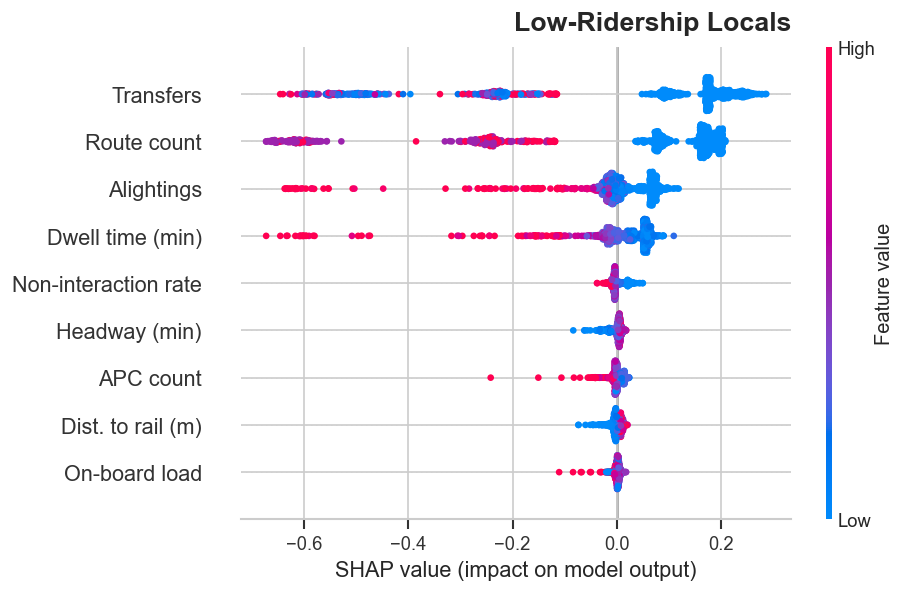

In [12]:
from pathlib import Path
OUT_DIR = Path("shap_plots_ovr"); OUT_DIR.mkdir(exist_ok=True)

# ---------- Helper: top-right bold title ----------
def set_topright_title(text, fontsize=16, pad=10):
    ax = plt.gca()
    ax.set_title(text, loc='right', fontsize=fontsize, fontweight='bold', pad=pad)
    plt.subplots_adjust(top=0.90)

# --- Robust SHAP extractor for POSITIVE class across SHAP versions ---
def shap_pos_class_values(explainer, X):
    """
    Returns an (n_samples, n_features) array of SHAP values for the positive class.
    Handles these cases:
      - list [neg, pos]  -> returns pos
      - array (n, f)     -> returns as-is (already pos)
      - array (n, f, 2)  -> returns [:, :, 1] (pos prob)
    """
    sv = explainer.shap_values(X)
    if isinstance(sv, list):
        return sv[1] if len(sv) >= 2 else sv[-1]
    sv = np.asarray(sv)
    if sv.ndim == 3 and sv.shape[-1] == 2:
        return sv[:, :, 1]
    if sv.ndim == 2:
        return sv
    raise ValueError(f"Unexpected SHAP shape: {sv.shape}")

# 1) Load data
df = pd.read_csv('stop_overall_averages_with_dist_clustered.csv')

# 2) Features & target
features = [
    'avg_headway_min',
    'avg_dwell_mins',
    'num_unique_routes',
    'avg_APC_count',
    'avg_psgrload',
    'avg_psgroff',
    'avg_transfer',
    'NI_rate',
    'nearest_station_dist_m'
]
X = df[features]
y = df['cluster']

# Pretty names for plots
DISPLAY_NAME = {
    'avg_headway_min':        'Headway (min)',
    'avg_dwell_mins':         'Dwell time (min)',
    'num_unique_routes':      'Route count',
    'avg_APC_count':          'APC count',
    'avg_psgrload':           'On-board load',
    'avg_psgroff':            'Alightings',
    'avg_transfer':           'Transfers',
    'NI_rate':                'Non-interaction rate',
    'nearest_station_dist_m': 'Dist. to rail (m)',
}

# Map cluster id -> type name (filenames/titles)
TYPE_NAME_MAP = {
    0: 'Multi-route Destinations',
    1: 'Rail-Adjacent Distributors',
    2: 'High-Demand Hubs',
    3: 'Low-Ridership Locals'
}

print("Unique classes in y:", np.unique(y))
print("Class distribution:\n", pd.Series(y).value_counts())

# 3) Stratified split (shared across all one-vs-rest runs)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

# 4) Scale (keeps parity with your earlier pipeline)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# A display-friendly DF for SHAP (rename columns so we don't pass feature_names)
X_test_df = pd.DataFrame(X_test, columns=features)
X_test_df_disp = X_test_df.copy()
X_test_df_disp.columns = [DISPLAY_NAME[f] for f in features]

# 5) RF grid (same spirit as yours)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': [None, 'balanced']
}

# 6) Train 4 separate binary RFs and plot SHAP (beeswarm) for each
for cls in sorted(pd.unique(y)):
    cls_name = TYPE_NAME_MAP.get(cls, f"Type {cls}")
    print("\n"+"="*80)
    print(f"Training one-vs-rest RF for class {cls}: {cls_name}")
    print("="*80)

    # Binary target: this class vs rest
    y_train_bin = (y_train == cls).astype(int)
    y_test_bin  = (y_test  == cls).astype(int)

    # CV folds: ensure both classes present in each fold
    min_class = min(y_train_bin.sum(), len(y_train_bin) - y_train_bin.sum())
    cv = 2 if min_class < 3 else 3
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    rf = RandomForestClassifier(random_state=42)
    grid = GridSearchCV(
        rf, param_grid, cv=skf, scoring='f1',
        n_jobs=-1, verbose=1
    )
    grid.fit(X_train_scaled, y_train_bin)
    best_rf = grid.best_estimator_
    print("Best RF parameters (OVR):", grid.best_params_)

    y_pred = best_rf.predict(X_test_scaled)
    print("\nTest Accuracy:", accuracy_score(y_test_bin, y_pred))
    print("\nClassification Report:\n", classification_report(y_test_bin, y_pred, digits=3))

    # ---- SHAP: explain probability of the POSITIVE class ----
    try:
        explainer = shap.TreeExplainer(best_rf, model_output="probability")
    except Exception:
        explainer = shap.TreeExplainer(best_rf)

    sv_pos = shap_pos_class_values(explainer, X_test_scaled)  # (n_samples, n_features)
    print("sv_pos shape:", sv_pos.shape, "| X_test_df_disp shape:", X_test_df_disp.shape)

    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        sv_pos,
        X_test_df_disp,   # pretty names baked into df columns
        show=False
    )
    set_topright_title(cls_name, fontsize=16, pad=10)
    plt.tight_layout()
    safe_name = cls_name.replace(' ', '_').replace('/', '-')
    plt.savefig(OUT_DIR / f"ovr_shap_summary_{safe_name}.png", dpi=300)
    plt.show()


## 4. Multiclass separability and model comparison

To quantify how well the four types can be recovered from the indicators, we compare several multiclass classifiers (e.g., logistic regression, Random Forest, XGBoost) on a stratified train/test split. For each model, we compute:

- overall accuracy,  
- macro precision, recall, and F1,  
- macro ROC–AUC (one-vs-rest), and  
- log loss.  

This comparison serves two purposes: it checks whether the types are recoverable (i.e., not arbitrary groupings), and it helps us pick a strong reference model for detailed evaluation and SHAP-based interpretation.


In [11]:
def stratified_min1_train_test_split(X, y, test_size=0.30, random_state=42):
    """
    Ensures each class has at least one sample in BOTH train and test.
    Assumes each class has >= 2 samples.
    """
    rng = np.random.RandomState(random_state)
    X = pd.DataFrame(X).reset_index(drop=True)
    y = pd.Series(y).reset_index(drop=True)

    test_idx = []
    for _, idx in y.groupby(y).groups.items():
        idx = np.array(list(idx))
        rng.shuffle(idx)
        n = len(idx)
        n_test = max(1, int(round(n * test_size)))
        n_test = min(n - 1, n_test)  # leave >=1 for train
        test_idx.extend(idx[:n_test])

    test_idx = np.array(sorted(test_idx))
    train_mask = np.ones(len(y), dtype=bool)
    train_mask[test_idx] = False

    return X[train_mask].values, X[~train_mask].values, y[train_mask].values, y[~train_mask].values


# ---------- Config ----------
CSV = "stop_overall_averages_with_dist_clustered.csv"
FEATURES = [
    "avg_headway_min","avg_dwell_mins","num_unique_routes","avg_APC_count",
    "avg_psgrload","avg_psgroff","avg_transfer","NI_rate","nearest_station_dist_m"
]
TARGET = "cluster"
OUT = Path("model_comparison_all.csv")

# ---------- Load & filter ----------
df = pd.read_csv(CSV)
X = df[FEATURES]
y = df[TARGET].astype(int)

# drop classes with < 2 samples (so split is valid)
counts = pd.Series(y).value_counts()
ok_classes = counts[counts >= 2].index
mask = y.isin(ok_classes)
X, y = X[mask], y[mask]

# ---------- Split ----------
X_train, X_test, y_train, y_test = stratified_min1_train_test_split(
    X, y, test_size=0.30, random_state=42
)
classes = np.unique(y_train)
n_classes = len(classes)

# ---------- Generic evaluator ----------
def evaluate_model(name, pipe, param_grid):
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    gs = GridSearchCV(pipe, param_grid=param_grid, scoring="accuracy",
                      cv=cv, n_jobs=-1, verbose=0)
    gs.fit(X_train, y_train)
    best = gs.best_estimator_

    # predictions / probabilities
    y_pred = best.predict(X_test)
    if hasattr(best, "predict_proba"):
        y_proba = best.predict_proba(X_test)
    elif hasattr(best, "decision_function"):
        scores = best.decision_function(X_test)
        if scores.ndim == 1:  # binary margin → prob
            from scipy.special import expit
            p1 = expit(scores)
            y_proba = np.vstack([1 - p1, p1]).T
        else:  # multiclass margins → softmax
            from scipy.special import softmax
            y_proba = softmax(scores, axis=1)
    else:
        # fallback (rare): pseudo-probs from predictions
        y_proba = np.zeros((len(y_pred), n_classes))
        for i, c in enumerate(classes):
            y_proba[:, i] = (y_pred == c).astype(float)

    # metrics
    acc  = accuracy_score(y_test, y_pred)
    f1m  = f1_score(y_test, y_pred, average="macro")
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_test, y_pred, average="macro", zero_division=0)
    try:
        ll = log_loss(y_test, y_proba, labels=classes)
    except Exception:
        ll = np.nan
    try:
        y_test_bin = label_binarize(y_test, classes=classes)
        roc = roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr")
    except Exception:
        roc = np.nan

    return {
        "Method": name,
        "Accuracy": acc,
        "F1 Score (Macro)": f1m,
        "Log Loss": ll,
        "Precision (Macro)": prec,
        "Recall (Macro)": rec,
        "ROC AUC (Macro)": roc,
        "Best Params": gs.best_params_
    }


results = []

# ---------- Random Forest ----------
rf = Pipeline([
    ("scaler", StandardScaler()),  # harmless for RF; keeps pipelines consistent
    ("clf", RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1)),
])
rf_grid = {
    "clf__n_estimators": [300, 600],
    "clf__max_depth": [None, 12, 20],
    "clf__min_samples_split": [2, 5],
    "clf__min_samples_leaf": [1, 2],
}
results.append(evaluate_model("Random Forest", rf, rf_grid))

# ---------- Logistic  ----------
logit = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, multi_class="multinomial", solver="saga", n_jobs=-1)),
])
logit_grid = {"clf__C": [0.1, 1.0, 5.0], "clf__penalty": ["l1", "l2"]}
results.append(evaluate_model("Logistic", logit, logit_grid))

# ---------- ANN / MLP ----------
mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(max_iter=800, random_state=42)),
])
mlp_grid = {
    "clf__hidden_layer_sizes": [(64,), (128,), (128, 64)],
    "clf__alpha": [1e-4, 1e-3],
    "clf__learning_rate_init": [1e-3, 5e-4],
}
results.append(evaluate_model("ANN (MLP)", mlp, mlp_grid))

# ---------- SVM (RBF) ----------
svc = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(probability=True, random_state=42)),
])
svc_grid = {"clf__C": [0.5, 1.0, 5.0], "clf__gamma": ["scale", 0.1, 0.01]}
results.append(evaluate_model("SVM (RBF)", svc, svc_grid))

# ---------- XGBoost ----------
if HAS_XGB:
    xgb = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("clf", XGBClassifier(
            objective="multi:softprob", num_class=n_classes,
            eval_metric="mlogloss", n_estimators=300, random_state=42,
            n_jobs=-1, tree_method="hist"
        )),
    ])
    xgb_grid = {
        "clf__max_depth": [3, 5],
        "clf__learning_rate": [0.1, 0.05],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0],
    }
    results.append(evaluate_model("XGBoost", xgb, xgb_grid))

# ---------- LightGBM ----------
if HAS_LGBM:
    lgbm = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("clf", LGBMClassifier(objective="multiclass", num_class=n_classes,
                               random_state=42, n_estimators=400)),
    ])
    lgbm_grid = {
        "clf__learning_rate": [0.1, 0.05],
        "clf__max_depth": [-1, 10],
        "clf__num_leaves": [31, 63],
        "clf__subsample": [0.8, 1.0],
    }
    results.append(evaluate_model("LightGBM", lgbm, lgbm_grid))

# ---------- Results table ----------
res = pd.DataFrame(results)
cols = ["Method","Accuracy","F1 Score (Macro)","Log Loss",
        "Precision (Macro)","Recall (Macro)","ROC AUC (Macro)","Best Params"]
for c in cols[1:7]:
    res[c] = res[c].astype(float).round(3)
res = res[cols].sort_values("Accuracy", ascending=False).reset_index(drop=True)

print(res.to_string(index=False))
res.to_csv(OUT, index=False)
print(f"\nSaved: {OUT}")

latex_path = OUT.with_suffix(".tex")
latex = res.drop(columns=["Best Params"]).to_latex(index=False, escape=False)
latex_path.write_text(latex)
print(f"Saved LaTeX table: {latex_path}")


C:\Users\IT CITY\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\IT CITY\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


       Method  Accuracy  F1 Score (Macro)  Log Loss  Precision (Macro)  Recall (Macro)  ROC AUC (Macro)                                                                                                 Best Params
      XGBoost     0.981             0.968     0.043              0.976           0.963            1.000      {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.05, 'clf__max_depth': 3, 'clf__subsample': 0.8}
Random Forest     0.978             0.964     0.078              0.966           0.963            0.999 {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 600}
    ANN (MLP)     0.976             0.961     0.049              0.962           0.961            0.999              {'clf__alpha': 0.0001, 'clf__hidden_layer_sizes': (128, 64), 'clf__learning_rate_init': 0.001}
     Logistic     0.956             0.936     0.120              0.945           0.928            0.997                                                 

## 5. Final XGBoost model and separability diagnostics

We select a tuned multiclass XGBoost model as our main separability reference. In this final step, we:

- fit the tuned XGBoost on the training split and evaluate it on the held-out test set,  
- visualize performance via a confusion matrix and one-vs-rest ROC curves, and  
- use per-class SHAP beeswarm plots to understand which indicators drive separation across the four types.

These diagnostics confirm that the four clusters are not only interpretable but also highly recoverable from the original indicators, reinforcing the stability and behavioral meaning of the typology.


Train class counts:
 0     370
1     685
2     263
3    1365
Name: count, dtype: int64
Test class counts:
 0    158
1    294
2    112
3    585
Name: count, dtype: int64

Test Accuracy: 0.981

Classification Report:
               precision    recall  f1-score   support

           0      0.951     0.981     0.966       158
           1      0.967     0.993     0.980       294
           2      0.990     0.884     0.934       112
           3      0.995     0.993     0.994       585

    accuracy                          0.981      1149
   macro avg      0.976     0.963     0.968      1149
weighted avg      0.981     0.981     0.981      1149



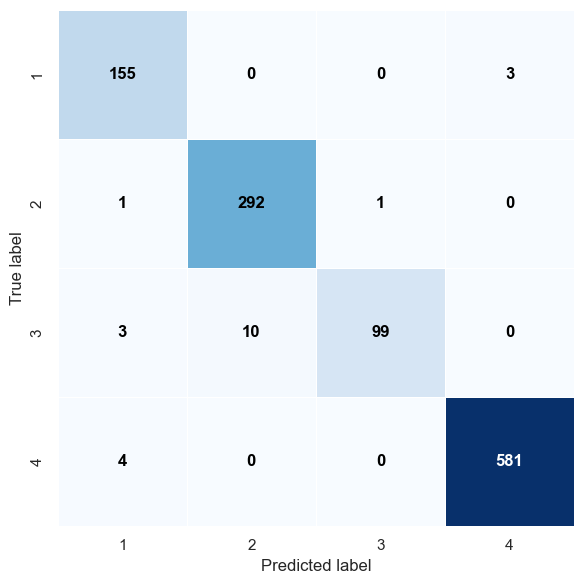

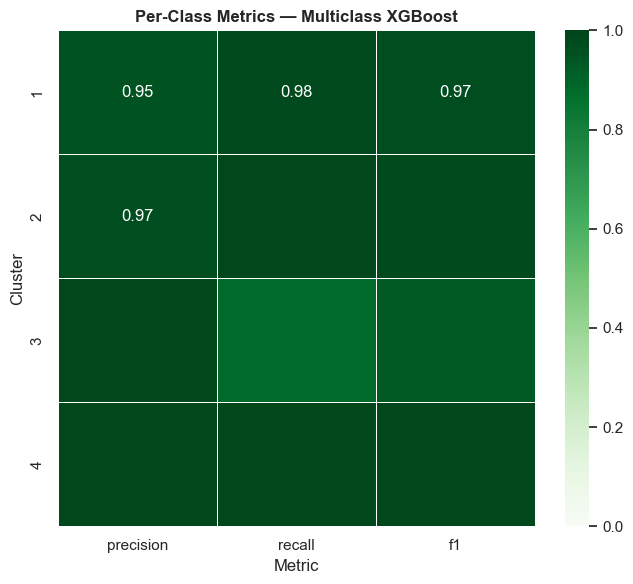

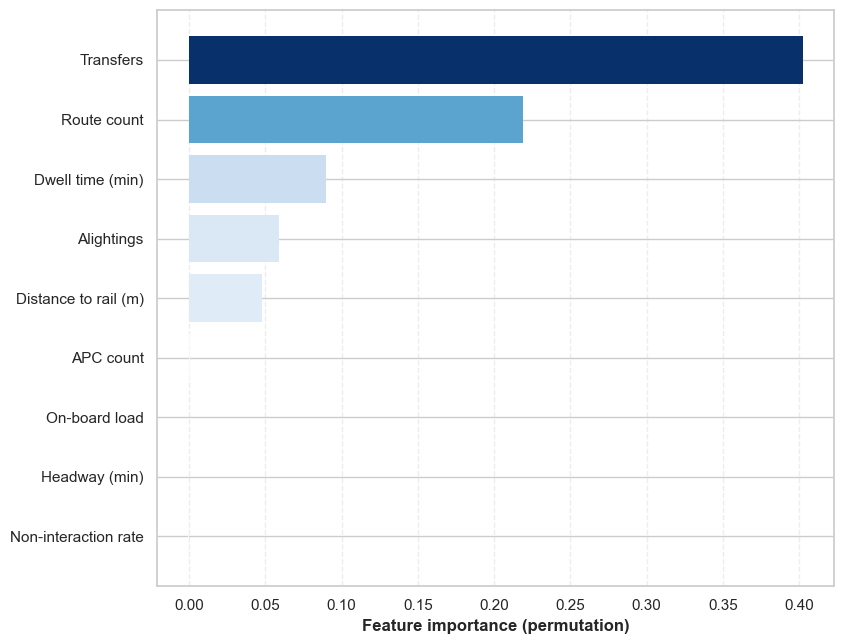

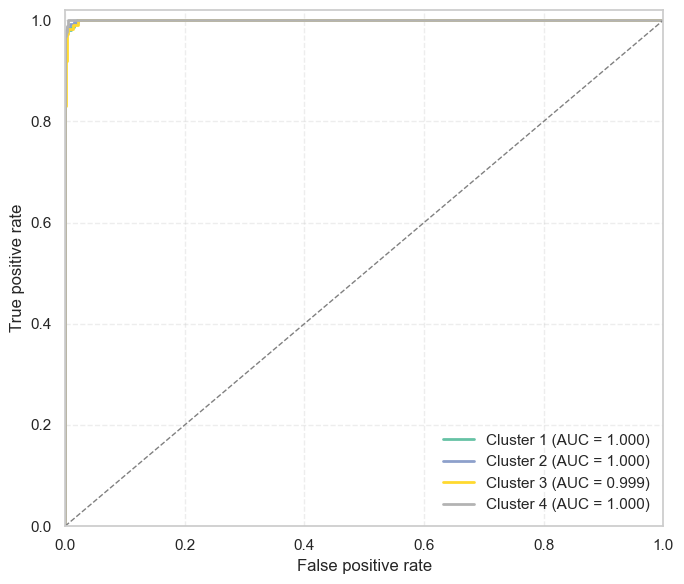

Macro ROC-AUC (test): 1.0
Saved: confusion_matrix_multiclass_xgb_blue.png, per_class_metrics_heatmap_xgb.png, feature_importance_permutation_xgb.png, roc_ovr_multiclass_xgb.png, per_class_metrics_table_xgb.csv


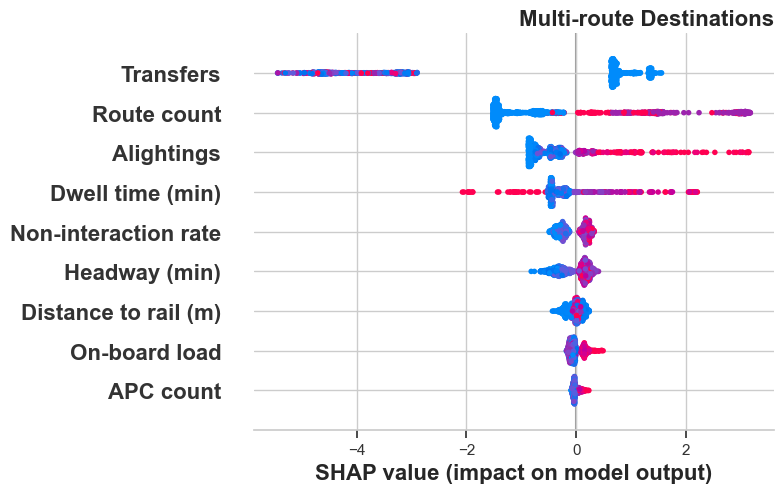

Saved SHAP plot: xgb_shap_plots\shap_beeswarm_Multi-route_Destinations.png


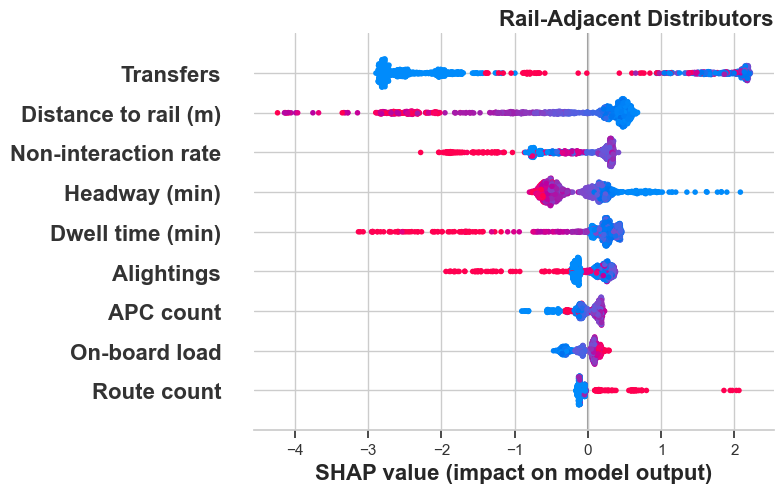

Saved SHAP plot: xgb_shap_plots\shap_beeswarm_Rail-Adjacent_Distributors.png


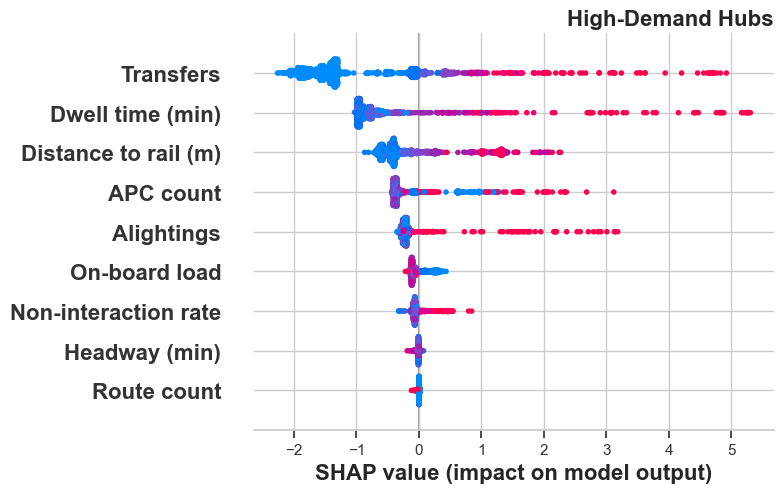

Saved SHAP plot: xgb_shap_plots\shap_beeswarm_High-Demand_Hubs.png


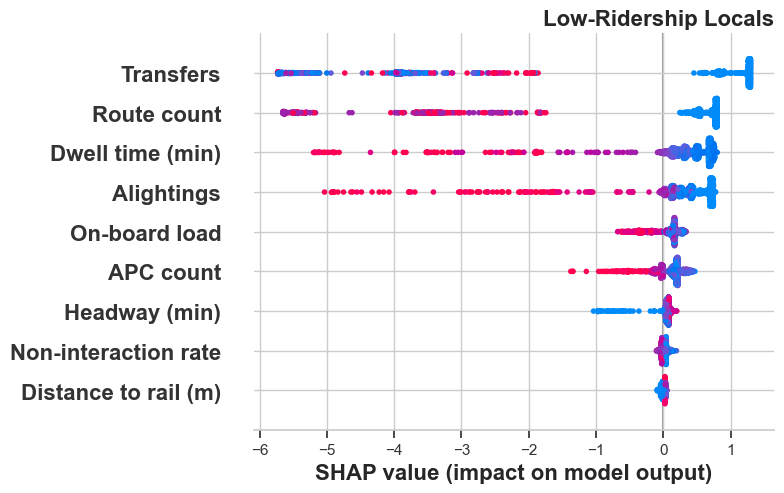

Saved SHAP plot: xgb_shap_plots\shap_beeswarm_Low-Ridership_Locals.png


In [2]:
sns.set(style="whitegrid")

def stratified_min1_train_test_split(X, y, test_size=0.30, random_state=42):
    """
    Ensures each class has at least one sample in BOTH train and test.
    Assumes each class has >= 2 samples.
    """
    rng = np.random.RandomState(random_state)
    X = pd.DataFrame(X).reset_index(drop=True)
    y = pd.Series(y).reset_index(drop=True)

    test_idx = []
    for _, idx in y.groupby(y).groups.items():
        idx = np.array(list(idx))
        rng.shuffle(idx)
        n = len(idx)
        n_test = max(1, int(round(n * test_size)))
        n_test = min(n - 1, n_test)  # at least 1 in train
        test_idx.extend(idx[:n_test])

    test_idx = np.array(sorted(test_idx))
    train_mask = np.ones(len(y), dtype=bool)
    train_mask[test_idx] = False

    X_train, X_test = X[train_mask].values, X[~train_mask].values
    y_train, y_test = y[train_mask].values, y[~train_mask].values

    print("Train class counts:\n", pd.Series(y_train).value_counts().sort_index())
    print("Test class counts:\n", pd.Series(y_test).value_counts().sort_index())
    return X_train, X_test, y_train, y_test

# 1) Load & features
CSV = "stop_overall_averages_with_dist_clustered.csv"

features = [
    "avg_headway_min",
    "avg_dwell_mins",
    "num_unique_routes",
    "avg_APC_count",
    "avg_psgrload",
    "avg_psgroff",
    "avg_transfer",
    "NI_rate",
    "nearest_station_dist_m",
]
target_col = "cluster"

# Pretty display names (used in plots + SHAP)
DISPLAY_NAME = {
    "avg_headway_min":        "Headway (min)",
    "avg_dwell_mins":         "Dwell time (min)",
    "num_unique_routes":      "Route count",
    "avg_APC_count":          "APC count",
    "avg_psgrload":           "On-board load",
    "avg_psgroff":            "Alightings",
    "avg_transfer":           "Transfers",
    "NI_rate":                "Non-interaction rate",
    "nearest_station_dist_m": "Distance to rail (m)",
}

df = pd.read_csv(CSV)
X = df[features]
y = df[target_col].astype(int)

# Drop classes with <2 samples (can’t split 1 into train+test)
min_samples_per_class = 2
class_counts = y.value_counts()
keep_mask = y.isin(class_counts[class_counts >= min_samples_per_class].index)
X, y = X[keep_mask], y[keep_mask]

# 2) Guaranteed train/test split
X_train, X_test, y_train, y_test = stratified_min1_train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Tree models don't need scaling, but we keep it for consistency
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)

# 3) XGBoost model
best_xgb = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y_train)),
    eval_metric="mlogloss",
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    tree_method="hist"
)
best_xgb.fit(X_train_s, y_train)

# 4) Evaluate + Confusion Matrix
y_pred = best_xgb.predict(X_test_s)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=3))

labels = np.sort(best_xgb.classes_)              # model's class order (e.g., 0..K-1)
display_labels = [str(int(c)+1) for c in labels] # if you present clusters as 1..K

# Confusion matrix — BLUE tones + manual annotations
cmx = confusion_matrix(y_test, y_pred, labels=labels)
fig, ax = plt.subplots(figsize=(6.8, 6.0))
sns.heatmap(
    cmx, annot=False, cmap="Blues", cbar=False,
    xticklabels=display_labels, yticklabels=display_labels,
    linewidths=0.6, linecolor="#ffffff", square=True, ax=ax
)
max_val = cmx.max() if cmx.size else 0
for i in range(cmx.shape[0]):
    for j in range(cmx.shape[1]):
        val = int(cmx[i, j])
        color = "white" if (max_val > 0 and val >= 0.6 * max_val) else "black"
        ax.text(j + 0.5, i + 0.5, str(val),
                ha="center", va="center",
                color=color, fontsize=12, fontweight="bold")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.tight_layout()
plt.savefig("confusion_matrix_multiclass_xgb_blue.png", dpi=300)
plt.show()

# Per-class metrics heatmap
prec, rec, f1, support = precision_recall_fscore_support(
    y_test, y_pred, labels=labels, zero_division=0
)
metrics_df = pd.DataFrame(
    {"precision": prec, "recall": rec, "f1": f1, "support": support},
    index=display_labels
)
plt.figure(figsize=(6.8, 6.0))
sns.heatmap(
    metrics_df[["precision", "recall", "f1"]].round(2),
    annot=True, cmap="Greens", vmin=0, vmax=1, cbar=True,
    linewidths=0.6, linecolor="white"
)
plt.title("Per-Class Metrics — Multiclass XGBoost", fontweight="bold")
plt.ylabel("Cluster")
plt.xlabel("Metric")
plt.tight_layout()
plt.savefig("per_class_metrics_heatmap_xgb.png", dpi=300)
plt.show()

# 5) Permutation importance — blue gradient
perm = permutation_importance(
    best_xgb, X_test_s, y_test, n_repeats=20, random_state=42, n_jobs=-1
)
perm_df = pd.DataFrame({
    "feature": features,
    "importance_mean": perm.importances_mean
}).sort_values("importance_mean", ascending=True)

perm_df["feature_label"] = perm_df["feature"].map(DISPLAY_NAME)

vals = perm_df["importance_mean"].to_numpy()
rng = (vals.max() - vals.min()) + 1e-12
norm = (vals - vals.min()) / rng
colors = cm.Blues(norm)

plt.figure(figsize=(8.6, 6.6))
plt.barh(perm_df["feature_label"], perm_df["importance_mean"], color=colors, edgecolor="none")
plt.xlabel("Feature importance (permutation)", fontweight="bold")
plt.ylabel("")
plt.grid(axis="x", linestyle="--", alpha=0.35)
plt.tight_layout()
plt.savefig("feature_importance_permutation_xgb.png", dpi=300)
plt.show()

# 6) ROC (One-vs-Rest) with AUC (test set)
y_proba = best_xgb.predict_proba(X_test_s)
y_test_bin = label_binarize(y_test, classes=labels)

plt.figure(figsize=(7.0, 6.0))
palette = cm.Set2(np.linspace(0, 1, len(labels)))  # distinct colors per class

auc_list = []
for i, c in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    auc_list.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, color=palette[i], label=f"Cluster {int(c)+1} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "--", color="gray", lw=1)
plt.xlim(0, 1); plt.ylim(0, 1.02)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(frameon=False, loc="lower right")
plt.grid(True, linestyle="--", alpha=0.35)
plt.tight_layout()
plt.savefig("roc_ovr_multiclass_xgb.png", dpi=300)
plt.show()

macro_auc = roc_auc_score(y_test_bin, y_proba, multi_class="ovr", average="macro")
print("Macro ROC-AUC (test):", round(macro_auc, 3))

# -------------------------
# 7) Save metrics table
# -------------------------
metrics_df.to_csv("per_class_metrics_table_xgb.csv")
print(
    "Saved: confusion_matrix_multiclass_xgb_blue.png, "
    "per_class_metrics_heatmap_xgb.png, "
    "feature_importance_permutation_xgb.png, "
    "roc_ovr_multiclass_xgb.png, "
    "per_class_metrics_table_xgb.csv"
)

# =========================================
# 8) SHAP for Multiclass XGBoost — per-type beeswarm
# =========================================

# ----- Type names (cluster labels) -----
TYPE_NAME_MAP = {
    0: "Multi-route Destinations",
    1: "Rail-Adjacent Distributors",
    2: "High-Demand Hubs",
    3: "Low-Ridership Locals",
}
def type_name(c):
    try:
        return TYPE_NAME_MAP[int(c)]
    except Exception:
        return f"Cluster {int(c)+1 if isinstance(c, (int, np.integer)) else c}"

# ----- Font scale just for SHAP plots -----
SCALE_SHAP = 1.4  # tweak if needed

# Pretty DataFrame for SHAP with display names
X_test_df = pd.DataFrame(X_test_s, columns=features)
X_test_df_disp = X_test_df.copy()
X_test_df_disp.columns = [DISPLAY_NAME.get(f, f) for f in X_test_df.columns]

# Build explainer
try:
    xgb_explainer = shap.TreeExplainer(best_xgb, model_output="probability")
except Exception:
    xgb_explainer = shap.TreeExplainer(best_xgb)

sv = xgb_explainer.shap_values(X_test_s)

# Normalize SHAP output to {class_label: (n_samples, n_features)}
sv_by_class = {}
if isinstance(sv, list):
    for i, c in enumerate(best_xgb.classes_):
        sv_by_class[int(c)] = sv[i]
else:
    sv = np.asarray(sv)
    if sv.ndim == 3 and sv.shape[-1] == len(best_xgb.classes_):
        for i, c in enumerate(best_xgb.classes_):
            sv_by_class[int(c)] = sv[:, :, i]
    else:
        raise ValueError(f"Unexpected SHAP shape for multiclass: {sv.shape}")

# Output folder for SHAP plots
SHAP_DIR = Path("xgb_shap_plots")
SHAP_DIR.mkdir(exist_ok=True)

# ---- Make and save one beeswarm per type ----
for c in best_xgb.classes_:
    c_int = int(c)
    title_txt = type_name(c_int)

    plt.figure(figsize=(9, 7))
    try:
        shap.summary_plot(
            sv_by_class[c_int],
            X_test_df_disp,
            show=False,
            color_bar=False
        )
    except TypeError:
        shap.summary_plot(
            sv_by_class[c_int],
            X_test_df_disp,
            show=False
        )

    ax = plt.gca()

    # X label
    ax.set_xlabel(
        "SHAP value (impact on model output)",
        fontsize=int(12 * SCALE_SHAP),
        fontweight="bold"
    )

    # y-ticks (feature names)
    for lbl in ax.get_yticklabels():
        lbl.set_fontsize(int(12 * SCALE_SHAP))
        lbl.set_fontweight("bold")

    # Title on the right
    ax.set_title(
        title_txt,
        loc="right",
        fontsize=int(12 * SCALE_SHAP),
        fontweight="bold",
        pad=6
    )

    safe_name = title_txt.replace(" ", "_").replace("/", "-")
    out_path = SHAP_DIR / f"shap_beeswarm_{safe_name}.png"
    plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved SHAP plot: {out_path}")




### Summary

This notebook reproduces the main analysis steps used in the bus stop typology study:

1. Selecting and fitting a four-component GMM to stop-level indicators,  
2. Profiling and naming the resulting types,  
3. Interpreting each type with one-vs-rest Random Forest SHAP, and  
4. Validating separability with a tuned multiclass XGBoost model.

The underlying raw transit data are not included here, but the code and aggregated features are structured so that the analysis can be rerun by authorized users with access to the source datasets.
